In [550]:
#Hello

In [551]:
import os
import pandas as pd
from torch.utils.data import DataLoader
from datetime import datetime

Load Datasets

In [552]:
#Load the fight data
fight_stats_df = pd.read_csv('datasets/ufc_fight_stat_data.csv')

#Load fight data
fight_data_df = pd.read_csv('datasets/ufc_fight_data.csv')

#Load fighter data 
fighter_data_df = pd.read_csv('datasets/ufc_fighter_data.csv')

#Load event data
event_data_df = pd.read_csv('datasets/ufc_event_data.csv')

print(fighter_data_df.columns)

Index(['fighter_id', 'fighter_f_name', 'fighter_l_name', 'fighter_nickname',
       'fighter_height_cm', 'fighter_weight_lbs', 'fighter_reach_cm',
       'fighter_stance', 'fighter_dob', 'fighter_w', 'fighter_l', 'fighter_d',
       'fighter_nc_dq', 'fighter_url'],
      dtype='object')


Clean and Process Data

In [553]:
#Convert data columns to datetime format
fighter_data_df['fighter_dob'] = pd.to_datetime(fighter_data_df['fighter_dob'])

#Handle Missing Value, if any
fight_stats_df = fight_stats_df.dropna(subset=['fighter_id', 'ctrl_time'])
fight_data_df = fight_data_df.dropna(subset=['fight_id', 'f_1', 'f_2', 'winner', 'num_rounds'])
fighter_data_df = fighter_data_df.dropna(subset=['fighter_id', 'fighter_reach_cm', 'fighter_height_cm', 'fighter_stance', 'fighter_dob'])

fighter_data_df['fighter_nc_dq'] = fighter_data_df['fighter_nc_dq'].fillna(0)
fighter_data_df['fighter_stance'] = fighter_data_df['fighter_stance'].fillna(0)

event_data_df = event_data_df.dropna(subset=['event_id'])

#Encode categorical variables (if needed)
fighter_data_df['fighter_stance'] = fighter_data_df['fighter_stance'].map({'Orthodox': 0, 'Southpaw': 1, 'Switch': 2})



Merge Datasets

In [554]:
    
merged_df = pd.merge(fight_stats_df, fight_data_df, how='inner', on='fight_id')
merged_df = pd.merge(merged_df, fighter_data_df, how='inner', on='fighter_id')
# merged_df = pd.merge(merged_df, event_data_df, how='inner', on='event_id')

merged_df.to_csv('Andres.csv', index=False)

Cleaning

In [555]:
# Convert ctrl_time from minute format to seconds
def time_to_seconds(time_str):
    if time_str == '--':
        return None  # or any other suitable value, like np.nan
    else:
        minutes, seconds = map(int, time_str.split(':'))
        return minutes * 60 + seconds
    
merged_df['ctrl_time'] = merged_df['ctrl_time'].apply(time_to_seconds)
merged_df['finish_time'] = merged_df['finish_time'].apply(time_to_seconds)

#Convert each column to unique ID
merged_df['referee'] = pd.factorize(merged_df['referee'])[0]
# merged_df['event_city'] = pd.factorize(merged_df['event_city'])[0]
# merged_df['event_state'] = pd.factorize(merged_df['event_state'])[0]
# merged_df['event_country'] = pd.factorize(merged_df['event_country'])[0]
merged_df['result_details'] = pd.factorize(merged_df['result_details'])[0]
merged_df['title_fight'] = pd.factorize(merged_df['title_fight'])[0]
merged_df['weight_class'] = pd.factorize(merged_df['weight_class'])[0]
merged_df['gender'] = pd.factorize(merged_df['gender'])[0]
merged_df['result'] = pd.factorize(merged_df['result'])[0]

# NOTE: add column that contains value age at the event date

# Convert num_rounds to int
merged_df['num_rounds'] = pd.to_numeric(merged_df['num_rounds'], errors='coerce')


# Convert dob to age in years at the date of 3/25/2024
hard_coded_datetime = datetime(2024, 3, 25)
merged_df['fighter_dob'] = (hard_coded_datetime.date() - pd.to_datetime(merged_df['fighter_dob']).dt.date).apply(lambda x: x.days / 365.25)


# List of columns to drop (temp drop 'event_date' *add later*)

# Removed 'fight_id (, 'fight_id')

cols_to_drop = ['fight_url_x', 'fighter_url', 'fight_url_x', 'fight_url_y', 
                'fighter_url','fighter_nickname', 'fighter_l_name', 
                'fighter_f_name', 'finish_round','result_details'
                ]

# Drop the specified columns
merged_df = merged_df.drop(columns=cols_to_drop)

merged_df.sort_values(by=["fighter_id", 'fight_stat_id'], ascending=[True, True], inplace=True)
merged_df.to_csv('Andres(2).csv', index=False)


In [556]:
# data = pd.read_csv('Andres.csv')
# df = pd.DataFrame(data)

# result = pd.DataFrame()

# for fight_id in df['fight_id'].unique():
#     fight_df = df[df['fight_id'] == fight_id]
#     if len(fight_df) == 2:
#         base = fight_df.iloc[0].copy()
#         additional = fight_df.iloc[1]
        
#         # Adding new columns with 'f_2_' prefix from the second row
#         for col in fight_df.columns:
#             base[f'f_2_{col}'] = additional[col]
            
#         result = pd.concat([result, base.to_frame().T], ignore_index=True)
#     else:
#         result = pd.concat([result, fight_df], ignore_index=True)

# # Reordering columns if necessary and cleaning up the DataFrame
# result.reset_index(drop=True, inplace=True)

# merged_df = result
# merged_df.to_csv('Andres.csv', index=False)


In [557]:
# cols_to_drop = ['f_2_result', 'f_2_title_fight', 'f_2_num_rounds',
#                 'f_2_event_id', 'f_2_fight_stat_id', 'f_2_f_2', 'f_2_f_2',
#                 'f_2_referee', 'f_2_f_1', 'f_2_winner', 'f_2_weight_class'
# ]

# merged_df = merged_df.drop(columns=cols_to_drop)
# print(merged_df.columns)
# merged_df.to_csv('Andres.csv', index=False)

Create Cumulative Columns for Fighter 1

In [558]:
#create cumulative column for ctrl_time

merged_df.sort_values(by=["fighter_id", 'fight_stat_id'], ascending=[True, True], inplace=True)
merged_df["cumulative_ctrl_time"] = merged_df.groupby("fighter_id")["ctrl_time"].cumsum()

# Cumulative for reversals
merged_df["cumulative_reversals"] = merged_df.groupby("fighter_id")["reversals"].cumsum()

# for submission attempts
merged_df["cumulative_submission_att"] = merged_df.groupby("fighter_id")["submission_att"].cumsum()

# for takedown succession
merged_df["cumulative_takedown_succ"] = merged_df.groupby("fighter_id")["takedown_succ"].cumsum()

# for takedown attmepts 
merged_df["cumulative_takedown_att"] = merged_df.groupby("fighter_id")["takedown_att"].cumsum()

# for significant strike succession
merged_df["cumulative_sig_strikes_att"] = merged_df.groupby("fighter_id")["sig_strikes_att"].cumsum()

# for total strikes succession
merged_df["cumulative_total_strikes_succ"] = merged_df.groupby("fighter_id")["total_strikes_succ"].cumsum()

# for total strikes ATTEMPTS
merged_df["cumulative_total_strikes_att"] = merged_df.groupby("fighter_id")["total_strikes_att"].cumsum()

# for knockdowns
merged_df["cumulative_knockdowns"] = merged_df.groupby("fighter_id")["knockdowns"].cumsum()

# AVG finish Time
merged_df['avg_finish_time'] = merged_df.groupby('fighter_id')['finish_time'].transform(lambda x: x.expanding().mean())


# merged_df = pd.read_csv('final_set.csv')

print(merged_df.columns)
# print("num of columns" , merged_df.shape[1])
# print(merged_df['finish_time'])

merged_df.to_csv('Andres(2).csv', index=False)


Index(['fight_stat_id', 'fight_id', 'fighter_id', 'knockdowns',
       'total_strikes_att', 'total_strikes_succ', 'sig_strikes_att',
       'sig_strikes_succ', 'takedown_att', 'takedown_succ', 'submission_att',
       'reversals', 'ctrl_time', 'event_id', 'referee', 'f_1', 'f_2', 'winner',
       'num_rounds', 'title_fight', 'weight_class', 'gender', 'result',
       'finish_time', 'fighter_height_cm', 'fighter_weight_lbs',
       'fighter_reach_cm', 'fighter_stance', 'fighter_dob', 'fighter_w',
       'fighter_l', 'fighter_d', 'fighter_nc_dq', 'cumulative_ctrl_time',
       'cumulative_reversals', 'cumulative_submission_att',
       'cumulative_takedown_succ', 'cumulative_takedown_att',
       'cumulative_sig_strikes_att', 'cumulative_total_strikes_succ',
       'cumulative_total_strikes_att', 'cumulative_knockdowns',
       'avg_finish_time'],
      dtype='object')


Create Cumulative Columns for Fighter 2

In [559]:
# # merged_df.sort_values(by=["fighter_id", 'fight_stat_id'], ascending=[True, True], inplace=True)
# merged_df["f_2_cumulative_ctrl_time"] = merged_df.groupby("f_2")["f_2_ctrl_time"].cumsum()

# # Cumulative for reversals
# merged_df["f_2_cumulative_reversals"] = merged_df.groupby("f_2")["f_2_reversals"].cumsum()

# # for submission attempts
# merged_df["f_2_cumulative_submission_att"] = merged_df.groupby("f_2")["f_2_submission_att"].cumsum()

# # for takedown succession
# merged_df["f_2_cumulative_takedown_succ"] = merged_df.groupby("f_2")["f_2_takedown_succ"].cumsum()

# # for takedown attmepts 
# merged_df["f_2_cumulative_takedown_att"] = merged_df.groupby("f_2")["f_2_takedown_att"].cumsum()

# # for significant strike succession
# merged_df["f_2_cumulative_sig_strikes_att"] = merged_df.groupby("f_2")["f_2_sig_strikes_att"].cumsum()

# # for total strikes succession
# merged_df["f_2_cumulative_total_strikes_succ"] = merged_df.groupby("f_2")["f_2_total_strikes_succ"].cumsum()

# # for total strikes ATTEMPTS
# merged_df["f_2_cumulative_total_strikes_att"] = merged_df.groupby("f_2")["f_2_total_strikes_att"].cumsum()

# # for knockdowns
# merged_df["f_2_cumulative_knockdowns"] = merged_df.groupby("f_2")["f_2_knockdowns"].cumsum()

# # AVG finish Time
# merged_df['f_2_avg_finish_time'] = merged_df.groupby('f_2')['f_2_finish_time'].transform(lambda x: x.expanding().mean())

# merged_df.to_csv('Andres.csv', index=False)
# print(merged_df.columns)

In [560]:
merged_df.sort_values(by=["fight_id", 'fight_stat_id'], ascending=[True, True], inplace=True)
merged_df.to_csv('Andres(2).csv', index=False)


Remove original numeric stats

In [561]:
# # Need to remove original numeric stats because they are independent and would be hard to implement when creating features for model
temp_df = pd.read_csv('final_set.csv')

drop_cols = ['knockdowns', 'total_strikes_att', 'total_strikes_succ',
            'sig_strikes_att', 'sig_strikes_succ', 'takedown_att',
            'takedown_succ', 'submission_att', 'reversals', 'ctrl_time',
            'event_id', 'result', 'finish_time'
            ]
temp_df = merged_df.drop(columns=drop_cols)
temp_df = temp_df.iloc[:11000]
temp_df.sort_values(by=["fighter_id", 'fight_stat_id'], ascending=[True, True], inplace=True)
temp_df.to_csv('Andres.csv', index=False)

In [564]:
data = pd.read_csv('Andres(2).csv')
df = pd.DataFrame(data)


# Ensure the DataFrame is sorted by 'fight_id' and then by 'fight_stat_id' if necessary
df.sort_values(by=['fight_id', 'fight_stat_id'], inplace=True)

# Split the DataFrame into two: one for each row in the duplicate pairs
first_rows = df.iloc[::2, :].reset_index(drop=True)
second_rows = df.iloc[1::2, :].reset_index(drop=True)

# Rename the columns of the second DataFrame to have 'f_2_' prefix
second_rows.columns = ['f_2_' + col for col in second_rows.columns]

# Concatenate the two DataFrames horizontally
merged_df = pd.concat([first_rows, second_rows], axis=1)

# Optionally, save the result to a new CSV
merged_df.to_csv('optimized_merged_fights.csv', index=False)

merged_df.sort_values(by=["fighter_id", 'fight_stat_id'], ascending=[True, True], inplace=True)
merged_df.to_csv('Andres(3).csv', index=False)


Random Forest Algo

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

merged_df = pd.read_csv('Andres.csv')
data = merged_df
df = pd.DataFrame(data)

# Creating a binary target variable indicating whether the fighter won or not.
df['is_winner'] = df['fighter_id'] == df['winner']

# Selecting features for the model
features = [
    "f_1","f_2","num_rounds", "title_fight", "weight_class", "gender", 
    "fighter_height_cm", "fighter_weight_lbs", "fighter_reach_cm", 
    "fighter_stance", "fighter_dob","fighter_w", "fighter_l", "fighter_d", "fighter_nc_dq",
    'cumulative_ctrl_time', 'cumulative_reversals', 'cumulative_submission_att', 
    'cumulative_takedown_succ', 'cumulative_takedown_att', 'cumulative_sig_strikes_att',
    'cumulative_total_strikes_succ', 'cumulative_total_strikes_att', 'cumulative_knockdowns',
    'avg_finish_time'
]
X = df[features]
y = df['is_winner']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizing the feature set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

# Predicting and evaluating the model
y_pred = clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print("Accuracy:", accuracy)

Accuracy: 0.6205211726384365


Preprocessing for Neural Network

In [ ]:
import numpy as np
import pandas as pd

#X_train_scaled is a numpy array; convert it to a DataFrame for easier manipulation
df_train_features = pd.DataFrame(X_train_scaled)

# Handling NaN values by imputation
df_train_features.fillna(df_train_features.mean(), inplace=True)

# Handling infinite values by replacing them with NaN and then imputing
df_train_features.replace([np.inf, -np.inf], np.nan, inplace=True)
df_train_features.fillna(df_train_features.mean(), inplace=True)

# Convert back to numpy array if necessary
X_train_scaled_clean = df_train_features.to_numpy()


Check for NaNs or infinite values in numpy


In [ ]:
# Example check for NaNs or infinite values in numpy
import numpy as np

# Assuming X_train_scaled is a numpy array
if np.isnan(X_train_scaled).any() or np.isinf(X_train_scaled).any():
    print("Training features contain NaN or infinite values.")
if np.isnan(y_train.values).any():
    print("Training labels contain NaN values.")
    

Neural Network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt


# Convert data to PyTorch tensors, ensuring y_train and y_test are converted from pandas Series to numpy arrays first
X_train_tensor = torch.tensor(X_train_scaled).float()
y_train_tensor = torch.tensor(y_train.to_numpy()).long()  
X_test_tensor = torch.tensor(X_test_scaled).float()
y_test_tensor = torch.tensor(y_test.to_numpy()).long()

# Creating Dataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Splitting train dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Neural Network Model with Dropout
class FightPredictor(nn.Module):
    def __init__(self):
        super(FightPredictor, self).__init__()
        self.fc1 = nn.Linear(X_train_scaled.shape[1], 128)
        self.dropout1 = nn.Dropout(0.5)  # Adding dropout
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)  # Adding dropout
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

model = FightPredictor()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Learning Rate Scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# Training with Early Stopping
num_epochs = 70
best_val_loss = float('inf')

training_losses = []
validation_losses = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    training_loss = running_loss / len(train_loader)
    training_losses.append(training_loss)

    # Validation loss
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    validation_loss = val_loss / len(val_loader)
    validation_losses.append(validation_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save the best model
        torch.save(model.state_dict(), 'best_model_TEST.pth')
    
    scheduler.step()  # Update learning rate
    
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}')

# Load the best model for testing
model.load_state_dict(torch.load('best_model_TEST.pth'))

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test dataset: {100 * correct / total}%')


Epoch 1/70, Training Loss: 0.6897732019424438, Validation Loss: 0.6567027270793915
Epoch 2/70, Training Loss: 0.6655735613838318, Validation Loss: 0.640634573996067
Epoch 3/70, Training Loss: 0.664300472505631, Validation Loss: 0.6407044306397438
Epoch 4/70, Training Loss: 0.6550684763539222, Validation Loss: 0.6555258221924305
Epoch 5/70, Training Loss: 0.6576034945826377, Validation Loss: 0.6622503101825714
Epoch 6/70, Training Loss: 0.6633088329145985, Validation Loss: 0.6431906446814537
Epoch 7/70, Training Loss: 0.6518995646507509, Validation Loss: 0.631342738866806
Epoch 8/70, Training Loss: 0.6499254722749034, Validation Loss: 0.6293698027729988
Epoch 9/70, Training Loss: 0.6451850581553674, Validation Loss: 0.6314225569367409
Epoch 10/70, Training Loss: 0.6563736690628913, Validation Loss: 0.6350666210055351
Epoch 11/70, Training Loss: 0.6335741021940785, Validation Loss: 0.6260853223502636
Epoch 12/70, Training Loss: 0.6325658021434661, Validation Loss: 0.623433630913496
Epoch

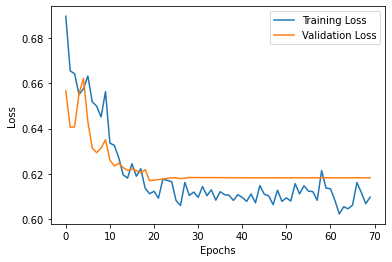

In [ ]:
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Testing New Unseen Data

In [ ]:
model = FightPredictor()
model.load_state_dict(torch.load('best_model.pth'))
model.eval

<bound method Module.eval of FightPredictor(
  (fc1): Linear(in_features=25, out_features=128, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)>

In [ ]:
with torch.no_grad():
    prediction = model(new_fight_tensor)
    predicted_winner = torch.argmax(prediction, dim=1).item()

# Assuming 0 represents f_1 and 1 represents f_2 as the winner
winner = "f_1" if predicted_winner == 0 else "f_2"
print(f"Predicted winner: {winner}")

NameError: name 'new_fight_tensor' is not defined